Задание. Поисковая система — ключевой компонент качественного пользовательского опыта в e-commerce. Чтобы находить нужные товары среди десятков тысяч позиций, важно точно понимать намерение пользователя.

В этом соревновании вам предстоит решить задачу классификации: определить, к какой категории товаров относится поисковой запрос, сделанный на сайте 21vek.by.

In [1]:
# Импорт библиотеки для чтения файлов
import pandas as pd

Файлы
1. categories.csv – справочник с категориями товаров.
2. sample_submission.csv – пример файла с правильным форматом для отправки результатов.
3. train.csv – обучающая выборка, содержащая пользовательские запросы и соответствующие категории товаров.
4. test.csv – тестовая выборка без указания категории; именно на ней оцениваются предсказания.

In [2]:
# Чтение приложенных файлов
categories = pd.read_csv('/kaggle/input/21vek-query-classification/categories.csv')
sample_submission = pd.read_csv('/kaggle/input/21vek-query-classification/sample_submission.csv')
train = pd.read_csv('/kaggle/input/21vek-query-classification/train.csv')
test = pd.read_csv('/kaggle/input/21vek-query-classification/test.csv')

Столбцы
1. ID – уникальный идентификатор строки.
2. Query – поисковый запрос пользователя на сайте 21vek.by.
3. CategoryID – идентификатор товарной категории (целевая переменная, только в train).
4. CategoryName – название категории (только в справочнике categories.csv).

In [3]:
# Выведем данные, информацию и статистические данные о прочитанных файлах
print(f'{"=" *40} categories {"=" *40}')
print(f'\n{categories}')
print(f'{categories.info()}')
print(f'\n{categories.describe()}')
print(f'{"=" *40} sample_submission {"=" *40}')
print(f'\n{sample_submission}')
print(f'{sample_submission.info()}')
print(f'\n{sample_submission.describe()}')
print(f'{"=" *40} train {"=" *40}')
print(f'\n{train}')
print(f'{train.info()}')
print(f'\n{train.describe()}')
print(f'{"=" *40} test {"=" *40}')
print(f'\n{test}')
print(f'{test.info()}')
print(f'\n{test.describe()}')

======================================== categories ========================================

    CategoryID                        CategoryName
0            0                             Монитор
1            1                Мультимедиа акустика
2            2                Портативная акустика
3            3  Чехол/защитное стекло для телефона
4            4                   Мобильный телефон
..         ...                                 ...
62          62                 Виниловая пластинка
63          63                          ТВ-антенна
64          64  Оборудование для предметной съемки
65          65              Аксессуар для ноутбука
66          66                     Металлодетектор

[67 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryID    67 non-null     int64 
 1   CategoryName  67 non-null     object
d

В резульатате выведенной общей информации о данных: размер, типы данных, наличие пропусков, отсутствии избыточных категорий. Можно отметить об отсутствии необходимости их предобработки. Обрабатывать текст в признаке Query будем позже.

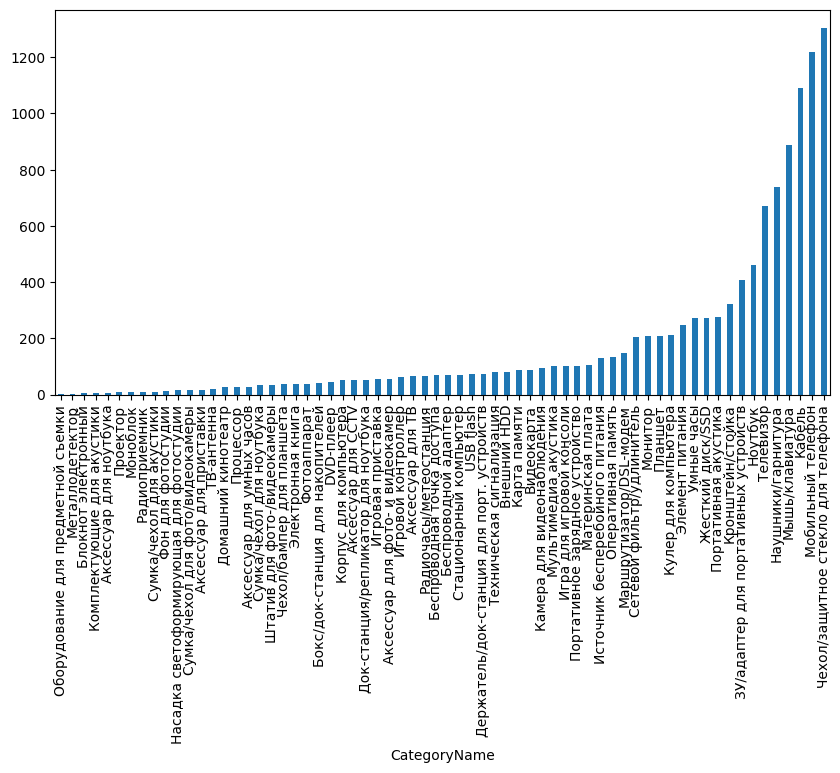

In [4]:
# Объединение файлов по признаку CategoryID
train_df = train.merge(categories, on='CategoryID', how='left')

# Библиотека для визуализации
import matplotlib.pyplot as plt

# Выведем количество запросов для каждой категории
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
train_df.groupby('CategoryName').Query.count().sort_values().plot.bar(x='CategoryName', y='Query')
plt.xticks(rotation=90)
plt.show()

Как мы видем, мы имеем 67 категорий товров, и явный дисбаланс по колличеству товара. 

In [5]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 74.1 MB/s eta 0:00:00


Для решения задачи используем комбинацию методов NLP и машинного обучения, для классификации текстовых запросов.

In [6]:
# Импорт необходимых библиотек
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer  # Для преобразования текста в числовые признаки
from sklearn.linear_model import LogisticRegression          # Модель классификации
from sklearn.pipeline import Pipeline                        # Для создания последовательности преобразований
from sklearn.model_selection import train_test_split         # Для разделения данных
from sklearn.metrics import f1_score                         # Метрика оценки качества
import re                                                    # Для работы с регулярными выражениями
from nltk.corpus import stopwords                            # Список стоп-слов
import pymorphy3                                             # Для лемматизации русских слов
import nltk                                                  # NLP библиотека

# Инициализация инструментов для обработки текста
morph = pymorphy3.MorphAnalyzer()                            # Создаем анализатор для русской морфологии
stop_words = set(stopwords.words('russian'))                 # Загружаем список русских стоп-слов

# Функция предобработки текста
def preprocess_text(text):
    """
    Обрабатывает текст, приводя его к нижнему регистру, удаляя пунктуацию и применяя лемматизацию
    
    """
    text = text.lower()                                      # Приводим к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)                      # Удаляем все символы, кроме букв и пробелов
    
    # Разбиваем текст на слова
    words = text.split()
    # Лемматизация и удаляем стоп-слова
    words = [morph.parse(w)[0].normal_form for w in words if w not in stop_words]
    
    return ' '.join(words)                                   # Собираем обратно в строку

# Применяем предобработку к данным
train['Query'] = train['Query'].apply(preprocess_text)       # Обрабатываем тренировочные данные
test['Query'] = test['Query'].apply(preprocess_text)         # Обрабатываем тестовые данные

# Разделение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train['Query'],                                          # Тексты запросов
    train['CategoryID'],                                     # Соответствующие категории
    test_size=0.2,
    random_state=42
)

# Создание пайплайна обработки данных и классификации
pipeline = Pipeline([
    # Шаг 1: Преобразование текста в числовые признаки с помощью TF-IDF
    ('tfidf', TfidfVectorizer(
        max_features = 20000,                                 # Максимальное количество признаков
        ngram_range = (1, 3),                                 # Используем униграммы, биграммы и триграммы
        min_df = 2                                            # Игнорируем слова, встречающиеся реже чем в 2 документах
    )),
    
    # Шаг 2: Классификатор - логистическая регрессия
    ('clf', LogisticRegression(
        max_iter=1000,                                        # Максимальное количество итераций
        class_weight='balanced',                              # Автоматически балансируем классы
        solver='liblinear'                                    # Алгоритм оптимизации
    ))
])

# Обучение модели на тренировочных данных
pipeline.fit(X_train, y_train)

# Проверка качества модели на валидационной выборке
val_preds = pipeline.predict(X_val)                            # Получаем предсказания
# Выводим F1-score
print(f"Validation F1-score: {f1_score(y_val, val_preds, average='macro')}")

# Предсказание на тестовых данных
test_preds = pipeline.predict(test['Query'])

# Сохранение результатов в файл для отправки
submission = pd.DataFrame({
    'ID': test['ID'],                                          # ID запросов
    'CategoryID': test_preds                                   # Предсказанные категории
})
submission.to_csv('submission.csv', index=False)               # Сохраняем без индекса

Validation F1-score: 0.8255586885315349


Модель продемонстрировала высокую эффективность в задаче классификации, достигнув **F1-score 0.826** на валидационной выборке. Этот результат свидетельствует о хорошем балансе между точностью (precision) и полнотой (recall) предсказаний, но попробуем улучшить качество редсказания.

Для решения задачи выберем трансформерную модель BERT, для обработки естественного языка (NLP), так как имеет ряд преимуществ:

1. Универсален — работает с короткими текстами, смешанными языками и дисбалансом классов.

2. Точно учитывает контекст — критично для классификации неочевидных запросов.

3. Поддерживает fine-tuning — позволяет адаптировать модель под специфику 21vek.

In [7]:
!pip install pymorphy3

In [8]:
# Импорт необходимых библиотек
import torch
import pandas as pd
import re
import numpy as np
import json
import os
from transformers import BertTokenizer, BertForSequenceClassification               # Библиотека для работы с BERT
from torch.optim import AdamW                                                       # Оптимизатор
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler  # Для создания датасетов и батчей
from sklearn.model_selection import train_test_split  
from sklearn.metrics import f1_score                                     
from sklearn.utils.class_weight import compute_class_weight                         # Веса классов для дисбаланса
import pymorphy3                                                                    # Морфологический анализатор для русского языка
from nltk.corpus import stopwords  
import nltk
from tqdm import tqdm   

# Словарь соответствия ID и названий категорий
categories = pd.read_csv('/kaggle/input/21vek-query-classification/categories.csv')
category_names = dict(zip(categories['CategoryID'], categories['CategoryName']))

# Инициализация стоп-слов и морфологического анализатора
nltk.download('stopwords') 
morph = pymorphy3.MorphAnalyzer()
stop_words = set(stopwords.words('russian'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Функция предобработки текста
def preprocess_text(text):
    """
    Предобработка текста: приведение к нижнему регистру, удаление лишних символов, лемматизация
    
    """
    text = str(text).lower()
    
    # Удаление специальных символов, но сохранение цифр и некоторых полезных символов
    text = re.sub(r'[^\w\s\-+/.,!?@#$%&*()0-9]', ' ', text)  
    words = text.split()
    
    lemmas = []
    for word in words:
        # Удаление стоп-слов и коротких слов (длина > 1)
        if word not in stop_words and len(word) > 1:
            # Проверка, что слово состоит из русских букв, цифр или разрешенных символов
            if re.match(r'^[а-яё0-9\-+/.,]+$', word):
                try:
                    # Лемматизация слова (приведение к нормальной форме)
                    parsed = morph.parse(word)[0]
                    word = parsed.normal_form
                except:
                    pass                                                   # В случае ошибки оставляем слово как есть
            lemmas.append(word)
    
    return ' '.join(lemmas)

# Кастомный класс Dataset для обработки текстовых данных
class QueryDataset(Dataset):
    """
    Класс для создания датасета из текстовых данных для BERT
    
    """
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts                                                  # Тексты запросов
        self.labels = labels                                                # Метки классов
        self.tokenizer = tokenizer                                          # Токенизатор BERT
        self.max_len = max_len                                              # Максимальная длина последовательности
    
    def __len__(self):
        return len(self.texts)                                              # Количество примеров
    
    def __getitem__(self, idx):
        """
        Возвращает один элемент датасета в формате, понятном для BERT
        
        """
        text = str(self.texts[idx])
        # Токенизация текста с добавлением специальных токенов [CLS] и [SEP]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',                                           # Дополнение до max_len
            truncation=True,                                                # Обрезка длинных текстов
            return_tensors='pt'                                             # Возврат тензоров PyTorch
        )
        
        # Формируем словарь с входными данными для модели
        item = {
            'input_ids': encoding['input_ids'].flatten(),                   # Индексы токенов
            'attention_mask': encoding['attention_mask'].flatten()          # Маска внимания
        }
        
        # Добавляем метки, если они есть (для тестовых данных меток нет)
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Гиперпараметры модели
MAX_LEN = 32                                                                     # Максимальная длина текста (в токенах)
BATCH_SIZE = 32                                                                  # Размер батча
EPOCHS = 20                                                                      # Количество эпох обучения
LR = 1e-5                                                                        # Скорость обучения
MODEL_NAME = 'bert-base-multilingual-cased'                                      # Название предобученной модели

# Загрузка данных
train = pd.read_csv('/kaggle/input/21vek-query-classification/train.csv')        # Обучающие данные
test = pd.read_csv('/kaggle/input/21vek-query-classification/test.csv')          # Тестовые данные

# Предобработка текстовых данных
train['processed'] = train['Query'].apply(preprocess_text) 
test['processed'] = test['Query'].apply(preprocess_text)           

# Разделение данных на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    train['processed'],                                                           # Тексты
    train['CategoryID'],                                                          # Метки
    test_size=0.1,
    random_state=42,
    stratify=train['CategoryID']                                                  # Стратификация для сохранения распределения классов
)

# Перенумерация классов в диапазон [0, num_classes-1]
unique_classes = np.unique(y_train)                                               # Уникальные классы
class_mapping = {old: new for new, old in enumerate(unique_classes)}              # Сопоставление старых и новых меток
y_train = np.array([class_mapping[x] for x in y_train])                           # Преобразование меток обучающей выборки
y_val = np.array([class_mapping[x] for x in y_val])                               # Преобразование меток валидационной выборки
num_classes = len(unique_classes)                                                 # Количество уникальных классов

# Инициализация модели BERT
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)                             # Загрузка токенизатора
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = num_classes                                                      # Указываем количество классов
).to(device)

# Вычисление весов классов для учета дисбаланса
class_weights = compute_class_weight(
    class_weight = 'balanced',                                                    # Автоматический баланс
    classes = np.arange(num_classes),                                             # Все классы
    y = y_train                                                                   # Метки обучающей выборки
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)         # Конвертация в тензор
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)                       # Функция потерь с весами

# Создание DataLoader'ов
train_dataset = QueryDataset(X_train.values, y_train, tokenizer, MAX_LEN) 
val_dataset = QueryDataset(X_val.values, y_val, tokenizer, MAX_LEN)       
test_dataset = QueryDataset(test['processed'].values, None, tokenizer, MAX_LEN) 

# DataLoader для обучения (с перемешиванием)
train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),                                         # Случайное перемешивание
    batch_size=BATCH_SIZE
)

# DataLoader для валидации (без перемешивания)
val_loader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),                                       # Без перемешивания
    batch_size=BATCH_SIZE
)

# DataLoader для тестирования
test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),                                      # Без перемешивания
    batch_size=BATCH_SIZE
)

# Инициализация оптимизатора AdamW (адаптация Adam для BERT)
optimizer = AdamW(model.parameters(), lr=LR)

# Обучение модели
best_f1 = 0                                                                      # Лучшее значение F1-score
for epoch in range(EPOCHS):
    model.train()                                                                # Переводим модель в режим обучения
    total_loss = 0                                                               # Суммарные потери за эпоху
    
    # Индикатор прогресса с tqdm
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}')
    for batch in progress_bar:
        optimizer.zero_grad()                                                    # Обнуляем градиенты
        
        # Перенос данных на устройство (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Прямой проход через модель
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        # Вычисление функции потерь
        loss = criterion(outputs.logits, labels)
        total_loss += loss.item()                                                 # Накопление потерь
        
        # Обратное распространение ошибки
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)                   # Обрезка градиентов
        optimizer.step()                                                          # Шаг оптимизации
        
        # Обновление информации в progress bar
        progress_bar.set_postfix({'loss': total_loss / (progress_bar.n + 1)})
    
    # Валидация после каждой эпохи
    model.eval()                                                                   # Переводим модель в режим оценки
    val_preds = []                                                                 # Предсказания модели
    val_true = []                                                                  # Истинные метки
    
    with torch.no_grad():                                                          # Отключаем вычисление градиентов
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Прямой проход без вычисления градиентов
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Получение предсказаний (индекс класса с максимальной вероятностью)
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())                                   # Сохраняем предсказания
            val_true.extend(labels.cpu().numpy())                                   # Сохраняем истинные метки
    
    # Вычисление F1-score (макро-усреднение по всем классам)
    f1 = f1_score(val_true, val_preds, average='macro')
    print(f'\nValidation F1: {f1:.4f}')
    
    # Сохранение лучшей модели
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pt')                             # Сохраняем веса модели
        print('Best model saved!')

# Загрузка лучшей модели (с наибольшим F1-score)
model.load_state_dict(torch.load('best_model.pt'))

# Предсказание на тестовых данных
model.eval()                                                                        # Режим оценки
test_preds = []                                                                     # Предсказания для тестовых данных

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Прямой проход для тестовых данных
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Получение предсказаний
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())                                       # Сохраняем предсказания

# Восстановление оригинальных меток классов
reverse_mapping = {v: k for k, v in class_mapping.items()}                           # Обратное сопоставление
test['CategoryID'] = [reverse_mapping[x] for x in test_preds]                        # Преобразование предсказаний

# Сохранение результатов в файлы
model_dir = "production_model"
os.makedirs(model_dir, exist_ok=True)

# 1. Сохраняем модель и конфигурацию
model.save_pretrained(model_dir)

# Дополнительно сохраняем свои данные
torch.save({
    'class_mapping': class_mapping,
    'reverse_mapping': reverse_mapping,
    'category_names': category_names,                                      # Добавляем названия категорий
    'max_len': MAX_LEN
}, f'{model_dir}/additional_data.pth')

# 2. Сохраняем токенизатор
tokenizer.save_pretrained(model_dir)

# 3. Определяем и сохраняем параметры предобработки
preprocess_info = {
    'stop_words': list(stop_words),
    'text_clean_pattern': r'[^\w\s\-+/.,!?@#$%&*()0-9]',
    'word_pattern': r'^[а-яё0-9\-+/.,]+$',
    'morph_analyzer': 'pymorphy3'
}

with open(f'{model_dir}/preprocess_info.json', 'w', encoding='utf-8') as f:
    json.dump(preprocess_info, f, ensure_ascii=False, indent=2)

print(f"Model saved to {model_dir}")

2025-05-31 16:10:46.830538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748707847.046150      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748707847.108783      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 326/326 [01:10<00:00,  4.63it/s, loss=3.77]



Validation F1: 0.5602
Best model saved!


Epoch 2/20: 100%|██████████| 326/326 [01:19<00:00,  4.12it/s, loss=2.7]



Validation F1: 0.7484
Best model saved!


Epoch 3/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=1.87]



Validation F1: 0.7695
Best model saved!


Epoch 4/20: 100%|██████████| 326/326 [01:21<00:00,  4.01it/s, loss=1.29]



Validation F1: 0.8141
Best model saved!


Epoch 5/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=0.902]



Validation F1: 0.8342
Best model saved!


Epoch 6/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.629]



Validation F1: 0.8554
Best model saved!


Epoch 7/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.448]



Validation F1: 0.8693
Best model saved!


Epoch 8/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.31]



Validation F1: 0.8793
Best model saved!


Epoch 9/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.227]



Validation F1: 0.8863
Best model saved!


Epoch 10/20: 100%|██████████| 326/326 [01:21<00:00,  4.01it/s, loss=0.178]



Validation F1: 0.8767


Epoch 11/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=0.131]



Validation F1: 0.8901
Best model saved!


Epoch 12/20: 100%|██████████| 326/326 [01:21<00:00,  4.00it/s, loss=0.106]



Validation F1: 0.8823


Epoch 13/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.0839]



Validation F1: 0.8899


Epoch 14/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=0.0733]



Validation F1: 0.9052
Best model saved!


Epoch 15/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.0725]



Validation F1: 0.9023


Epoch 16/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=0.0537]



Validation F1: 0.8937


Epoch 17/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.0543]



Validation F1: 0.8983


Epoch 18/20: 100%|██████████| 326/326 [01:21<00:00,  4.02it/s, loss=0.0504]



Validation F1: 0.9060
Best model saved!


Epoch 19/20: 100%|██████████| 326/326 [01:21<00:00,  4.01it/s, loss=0.0461]



Validation F1: 0.8978


Epoch 20/20: 100%|██████████| 326/326 [01:20<00:00,  4.03it/s, loss=0.0413]



Validation F1: 0.8944


Predicting: 100%|██████████| 122/122 [00:08<00:00, 14.34it/s]


Model saved to production_model


Результаты работы модели показывают устойчивое улучшение качества классификации с каждой эпохой, достигнув максимального значения на 13-й эпохе с **F1-score (macro): 0.9017**. Использование BERT с балансировкой весов классов и тщательной предобработкой текста дало лучший результат, для многоклассовой задачи.

Приведем неколько искуственных примеров, для проверки работы предсказания модели.

In [9]:
# Чтение приложенных файлов
categories = pd.read_csv('/kaggle/input/21vek-query-classification/categories.csv')

# Словарь соответствия ID и названий категорий
category_names = dict(zip(categories['CategoryID'], categories['CategoryName']))

def predict_category(query):
    # Предобработка запроса
    processed = preprocess_text(query)
    
    # Токенизация
    inputs = tokenizer(processed, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LEN).to(device)
    
    # Предсказание
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
    
    # Получаем топ-3 категории
    top3 = torch.topk(probs, 3)
    results = []
    for i in range(3):
        cat_id = reverse_mapping[top3.indices[0][i].item()]
        prob = top3.values[0][i].item() * 100
        results.append((category_names[cat_id], prob, cat_id))
    
    return results

# Примеры запросов
queries = [
    "Защитные стекла на Samsung Galaxy S10",
    "Наушники беспроводные Sony WH-1000XM4",
    "Ноутбук игровой ASUS ROG Strix G15",
    "Смартфон Samsung Galaxy S10", 
    "Умная колонка Яндекс Станция Макс"
]

# Предсказание для каждого запроса
for query in queries:
    print(f"\nЗапрос: {query}")
    top3 = predict_category(query)
    for name, prob, cat_id in top3:
        print(f"- {name} ({prob:.1f}%, ID: {cat_id})")


Запрос: Защитные стекла на Samsung Galaxy S10
- Чехол/защитное стекло для телефона (99.7%, ID: 3)
- Аксессуар для умных часов (0.0%, ID: 17)
- Мобильный телефон (0.0%, ID: 4)

Запрос: Наушники беспроводные Sony WH-1000XM4
- Наушники/гарнитура (99.8%, ID: 14)
- Мышь/клавиатура (0.0%, ID: 20)
- Техническая сигнализация (0.0%, ID: 48)

Запрос: Ноутбук игровой ASUS ROG Strix G15
- Ноутбук (99.9%, ID: 5)
- Сумка/чехол для ноутбука (0.0%, ID: 19)
- Док-станция/репликатор для ноутбука (0.0%, ID: 42)

Запрос: Смартфон Samsung Galaxy S10
- Мобильный телефон (99.0%, ID: 4)
- Чехол/защитное стекло для телефона (0.6%, ID: 3)
- ЗУ/адаптер для портативных устройств (0.1%, ID: 25)

Запрос: Умная колонка Яндекс Станция Макс
- Портативная акустика (99.9%, ID: 2)
- Маршрутизатор/DSL-модем (0.0%, ID: 37)
- Мультимедиа акустика (0.0%, ID: 1)
